In [6]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import re
import glob


In [7]:
# Loading datasets from workspace-relative folders
from pathlib import Path

# Candidate roots (prefer drive-download first, then IAQF_Parshva data)
workspace_root = Path.cwd().resolve().parent
candidate_dirs = [
    workspace_root / "drive-download-20260219T015429Z-1-001",
    workspace_root / "IAQF_Parshva" / "IAQF" / "data",
]

# Known mappings for drive-download numbered files
named_paths = {
    "binance_eur": candidate_dirs[0] / "1.csv",
    "binance_usd": candidate_dirs[0] / "2.csv",
    "binance_usdc": candidate_dirs[0] / "3.csv",
    "kraken_eur": candidate_dirs[0] / "4.csv",
    "kraken_usd": candidate_dirs[0] / "5.csv",
    "kraken_usdc": candidate_dirs[0] / "6.csv",
}

# Fallback mappings from IAQF_Parshva data folder
fallback_names = {
    "binance_eur": "binance_btc_eur.csv",
    "binance_usd": "binance_btc_usd.csv",
    "binance_usdc": "binance_btc_usdc.csv",
    "kraken_eur": "kraken_btc_eur.csv",
    "kraken_usd": "kraken_btc_usd.csv",
    "kraken_usdc": "kraken_btc_usdc.csv",
}

for key, fname in fallback_names.items():
    if not named_paths[key].exists():
        named_paths[key] = candidate_dirs[1] / fname

# Load only available files and attach metadata
datasets = {}
for key, path in named_paths.items():
    if path.exists():
        df = pd.read_csv(path)
        ex, q = key.split("_", 1)
        df["exchange"] = ex
        df["quote"] = q
        datasets[key] = df

# Convenience variables (optional and may be None)
binance_usd = datasets.get("binance_usd")
binance_eur = datasets.get("binance_eur")
binance_usdc = datasets.get("binance_usdc")
binance_usdt = datasets.get("binance_usdt")

kraken_usd = datasets.get("kraken_usd")
kraken_eur = datasets.get("kraken_eur")
kraken_usdc = datasets.get("kraken_usdc")

print("Loaded datasets:", ", ".join(sorted(datasets.keys())))
for k, v in datasets.items():
    print(f"  {k}: {v.shape}")

Loaded datasets: binance_eur, binance_usd, binance_usdc, kraken_eur, kraken_usd, kraken_usdc
  binance_eur: (30240, 15)
  binance_usd: (30240, 15)
  binance_usdc: (30240, 15)
  kraken_eur: (30129, 10)
  kraken_usd: (30180, 10)
  kraken_usdc: (15719, 10)


In [8]:
# Optional auto-detect pass for additional BTC CSVs in candidate directories
extra_files = []
for d in candidate_dirs:
    if d.exists():
        extra_files.extend(sorted(d.glob("*.csv")))

for f in extra_files:
    base = f.stem.lower()
    key = None

    if base.startswith("binance_btc_"):
        quote = base.split("binance_btc_")[-1]
        key = f"binance_{quote}"
    elif base.startswith("kraken_btc_"):
        quote = base.split("kraken_btc_")[-1]
        key = f"kraken_{quote}"

    if key and key not in datasets:
        try:
            df = pd.read_csv(f)
            ex, q = key.split("_", 1)
            df["exchange"] = ex
            df["quote"] = q
            datasets[key] = df
        except Exception:
            pass

print("Datasets after auto-detect:")
for k, v in datasets.items():
    print(f"  {k}: {v.shape}")

Datasets after auto-detect:
  binance_eur: (30240, 15)
  binance_usd: (30240, 15)
  binance_usdc: (30240, 15)
  kraken_eur: (30129, 10)
  kraken_usd: (30180, 10)
  kraken_usdc: (15719, 10)


In [9]:
import os
print(os.getcwd())


c:\Users\Shreya Sandurkar\Downloads\IAQF\IAQF-Jun


In [10]:
# -----------------------------
# Data cleaning / standardization
# -----------------------------
# Your screenshots show three formats:
# 1) Binance: timestamp string with timezone; columns include open/high/low/close/volume (+quote_vol, n_trades, ...)
# 2) Coinbase: timestamp string; columns include product_id, timestamp, open/high/low/close/volume
# 3) Kraken: timestamp is UNIX epoch seconds; columns include timestamp, open/high/low/close/volume/trades

def _parse_timestamp(series: pd.Series) -> pd.Series:
    """Parse timestamp column for both string timestamps and UNIX epoch seconds.

    Handles:
    - Kraken: UNIX epoch seconds (often 10 digits, may be int or numeric-looking strings)
    - Binance/Coinbase: ISO-like timestamp strings (often with timezone)
    """
    s = series.copy()

    # Try interpreting as UNIX epoch seconds (works even if dtype is object with numeric strings)
    num = pd.to_numeric(s, errors="coerce")
    nonnull_ratio = num.notna().mean()

    if nonnull_ratio > 0.9:
        med = num.dropna().median()
        # Typical epoch seconds ~ 1.6e9; allow a wide range
        if pd.notna(med) and (1e9 <= med <= 1e11):
            return pd.to_datetime(num, unit="s", utc=True, errors="coerce")

    # Otherwise fall back to regular datetime parsing
    return pd.to_datetime(s, utc=True, errors="coerce")


def clean_ohlcv(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Normalize column names
    df.columns = [str(c).strip().lower() for c in df.columns]

    # Timestamp
    if "timestamp" not in df.columns:
        raise ValueError("No 'timestamp' column found.")
    df["timestamp"] = _parse_timestamp(df["timestamp"])

    # Standardize trade count column name if needed
    if "n_trades" in df.columns and "trades" not in df.columns:
        df.rename(columns={"n_trades": "trades"}, inplace=True)

    # Numeric conversions
    for col in ["open", "high", "low", "close", "volume", "quote_vol", "trades"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # Keep only useful columns + metadata
    keep_cols = ["timestamp", "open", "high", "low", "close", "volume", "trades", "exchange", "quote"]
    for col in keep_cols:
        if col not in df.columns:
            df[col] = np.nan

    df = df[keep_cols]
    df.sort_values("timestamp", inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df


cleaned = {}
for name, df in datasets.items():
    try:
        cleaned[name] = clean_ohlcv(df)
    except Exception as e:
        print(f"[WARN] Failed to clean {name}: {e}")

# Replace datasets with cleaned versions for downstream cells
datasets = cleaned

# Long-format table for plotting
data = pd.concat(datasets.values(), ignore_index=True)
data["exchange"] = data["exchange"].astype(str).str.lower()
data["quote"] = data["quote"].astype(str).str.lower()

print("Available exchanges:", sorted(data["exchange"].dropna().unique()))
print("Available quote currencies:", sorted(data["quote"].dropna().unique()))
print("Time range:", data["timestamp"].min(), "->", data["timestamp"].max())

data.head()


Available exchanges: ['binance', 'kraken']
Available quote currencies: ['eur', 'usd', 'usdc']
Time range: 2023-03-01 00:00:00+00:00 -> 2023-03-21 23:59:00+00:00


,timestamp,open,high,low,close,volume,trades,exchange,quote
0,2023-03-01 00:00:00+00:00,22121.61,22134.71,22115.70,22124.53,5.60980,195,binance,eur
1,2023-03-01 00:01:00+00:00,22130.12,22133.13,22120.13,22122.67,0.41906,49,binance,eur
2,2023-03-01 00:02:00+00:00,22126.30,22142.10,22126.30,22142.10,0.45574,96,binance,eur
3,2023-03-01 00:03:00+00:00,22134.60,22143.46,22134.60,22137.43,0.05899,28,binance,eur
4,2023-03-01 00:04:00+00:00,22141.55,22155.69,22136.59,22155.69,0.77077,112,binance,eur


In [11]:
# Quick dtype check (after cleaning)
for name, df in datasets.items():
    print(f"\n{name}")
    print(df.dtypes)



binance_eur
timestamp    datetime64[us, UTC]
open                     float64
high                     float64
low                      float64
close                    float64
volume                   float64
trades                     int64
exchange                     str
quote                        str
dtype: object

binance_usd
timestamp    datetime64[us, UTC]
open                     float64
high                     float64
low                      float64
close                    float64
volume                   float64
trades                     int64
exchange                     str
quote                        str
dtype: object

binance_usdc
timestamp    datetime64[us, UTC]
open                     float64
high                     float64
low                      float64
close                    float64
volume                   float64
trades                     int64
exchange                     str
quote                        str
dtype: object

kraken_eur
timestamp    da

In [12]:
# Checking for missing values
for name, df in datasets.items():
    print(f"\nNaN counts for {name}")
    print(df.isna().sum())

for name, df in datasets.items():
    missing_rows = df[df.isna().any(axis=1)]
    print(f"{name}: {len(missing_rows)} rows with missing values")



NaN counts for binance_eur
timestamp    0
open         0
high         0
low          0
close        0
volume       0
trades       0
exchange     0
quote        0
dtype: int64

NaN counts for binance_usd
timestamp    0
open         0
high         0
low          0
close        0
volume       0
trades       0
exchange     0
quote        0
dtype: int64

NaN counts for binance_usdc
timestamp    0
open         0
high         0
low          0
close        0
volume       0
trades       0
exchange     0
quote        0
dtype: int64

NaN counts for kraken_eur
timestamp    0
open         0
high         0
low          0
close        0
volume       0
trades       0
exchange     0
quote        0
dtype: int64

NaN counts for kraken_usd
timestamp    0
open         0
high         0
low          0
close        0
volume       0
trades       0
exchange     0
quote        0
dtype: int64

NaN counts for kraken_usdc
timestamp    0
open         0
high         0
low          0
close        0
volume       0
tra

In [13]:
# Checking for timestamp gaps (assumes minute-level candles)
EXPECTED_FREQ = pd.Timedelta(minutes=1)

for name, df in datasets.items():
    print(f"\nTimestamp gaps for {name}:", end=" ")

    tmp = df[["timestamp"]].copy()
    tmp["time_diff"] = tmp["timestamp"].diff()

    gap_rows = tmp[tmp["time_diff"] > EXPECTED_FREQ]

    total_missing = 0
    for _, row in gap_rows.iterrows():
        gap = row["time_diff"]
        missing_count = int(gap / EXPECTED_FREQ) - 1
        total_missing += missing_count

    print(total_missing)

    if gap_rows.empty:
        print("No abnormal timestamp gaps detected.")
    else:
        for _, row in gap_rows.iterrows():
            prev_ts = tmp.loc[row.name - 1, "timestamp"]
            curr_ts = row["timestamp"]

            # UNCOMMENT THIS LINE TO PRINT DETAILS OF GAPS
            # print(f"Gap of {row['time_diff']} between {prev_ts} and {curr_ts}")



Timestamp gaps for binance_eur: 0
No abnormal timestamp gaps detected.

Timestamp gaps for binance_usd: 0
No abnormal timestamp gaps detected.

Timestamp gaps for binance_usdc: 0
No abnormal timestamp gaps detected.

Timestamp gaps for kraken_eur: 111

Timestamp gaps for kraken_usd: 60

Timestamp gaps for kraken_usdc: 14520


## New chart outputs (replacing all original plots)

You asked for three new types of plots:
1. Cross-exchange price differences for the same quote currency (USD / USDC / USDT / EUR).
2. Within each exchange, BTC pricing across different quote currencies in this window.
3. A standalone volume comparison chart to check whether this window shows turbulence.


In [ ]:
# Helper for plotting quote-series within one exchange on common axes
def plot_quotes_same_exchange(dfs, labels, title):
    if not dfs:
        raise ValueError("No dataframes provided to plot.")

    cleaned = []
    for df, label in zip(dfs, labels):
        tmp = df.copy()
        tmp["timestamp"] = pd.to_datetime(tmp["timestamp"], errors="coerce")
        tmp = tmp.dropna(subset=["timestamp", "close"]).sort_values("timestamp")
        cleaned.append((tmp, label))

    all_prices = np.concatenate([tmp["close"].to_numpy() for tmp, _ in cleaned if len(tmp) > 0])
    all_ts = pd.concat([tmp["timestamp"] for tmp, _ in cleaned if len(tmp) > 0], ignore_index=True)

    y_min, y_max = all_prices.min(), all_prices.max()
    x_min, x_max = all_ts.min(), all_ts.max()

    merged = None
    plt.figure(figsize=(14, 6))
    for tmp, label in cleaned:
        plt.plot(tmp["timestamp"], tmp["close"], label=label.upper(), linewidth=1.0)
        cols = ["timestamp", "close"]
        renamed = tmp[cols].rename(columns={"close": f"close_{label}"})
        merged = renamed if merged is None else merged.merge(renamed, on="timestamp", how="outer")

    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return merged.sort_values("timestamp") if merged is not None else pd.DataFrame()

In [14]:
# Binance quote comparison (include only datasets that exist)
binance_plot_dfs = []
binance_plot_labels = []
for label, df in [
    ("usd", datasets.get("binance_usd")),
    ("usdt", datasets.get("binance_usdt")),
    ("usdc", datasets.get("binance_usdc")),
    ("eur", datasets.get("binance_eur")),
]:
    if df is not None:
        binance_plot_dfs.append(df)
        binance_plot_labels.append(label)

binance_merged = plot_quotes_same_exchange(
    dfs=binance_plot_dfs,
    labels=binance_plot_labels,
    title="BTC Price — Binance (Different Quote Currencies)"
)

NameError: name 'plot_quotes_same_exchange' is not defined

In [15]:
kraken_merged = plot_quotes_same_exchange(
    dfs=[
        kraken_usd,
        kraken_eur
    ],
    labels=[
        "usd",
        "eur"
    ],
    title="BTC Price — Kraken (Different Quote Currencies)"
)


NameError: name 'plot_quotes_same_exchange' is not defined

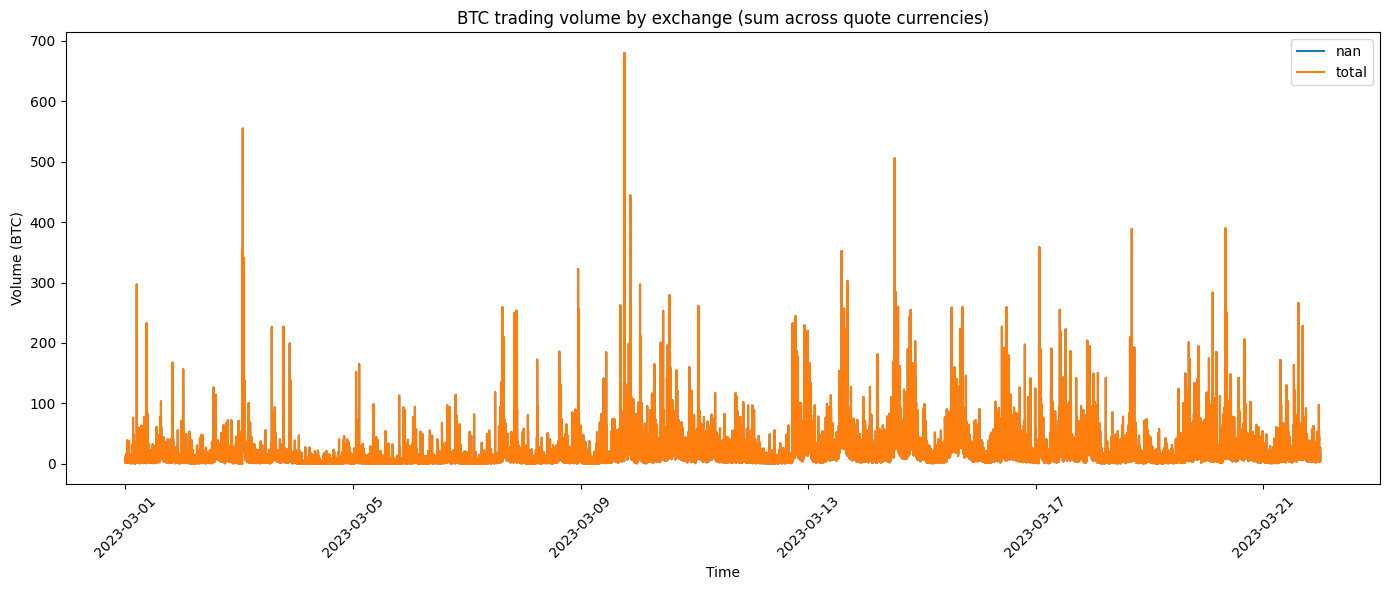

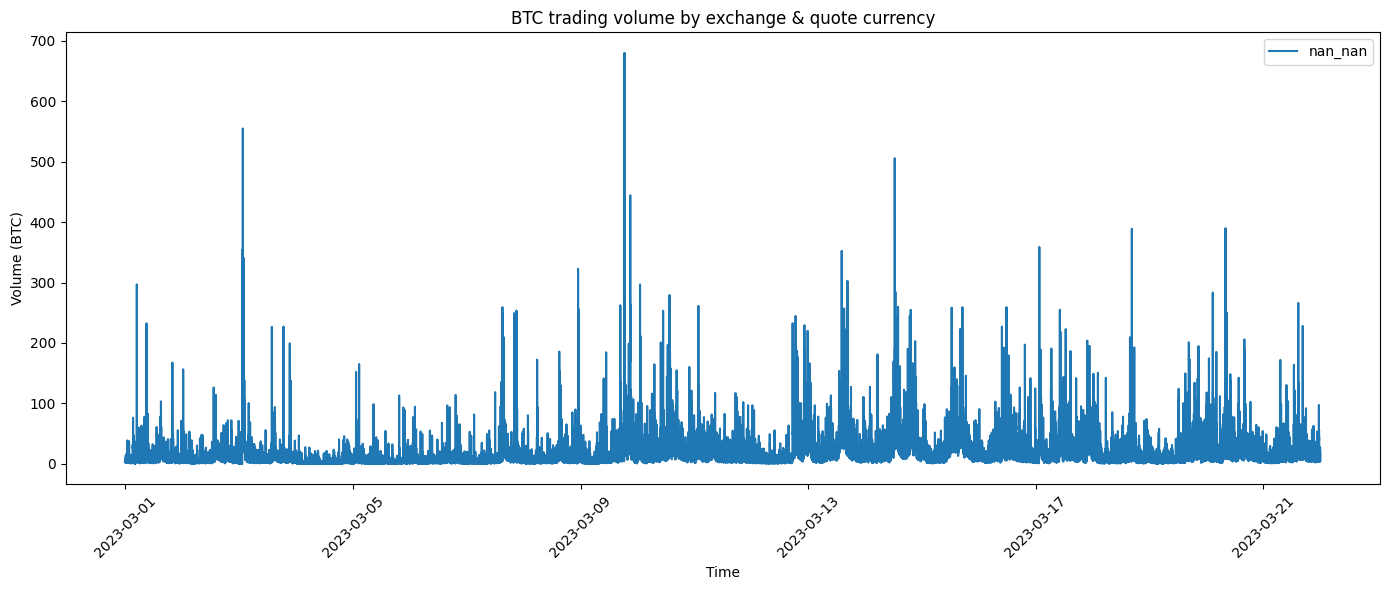

In [31]:
# 3) Volume comparison (standalone)
# (a) Sum volume across quote currencies for each exchange, then compare exchanges
vol_ex = (
    data.groupby(["timestamp", "exchange"])["volume"]
    .sum()
    .unstack("exchange")
    .sort_index()
)

plt.figure(figsize=(14, 6))
for ex in vol_ex.columns:
    plt.plot(vol_ex.index, vol_ex[ex], label=ex)
plt.plot(vol_ex.index, vol_ex.sum(axis=1), label="total")
plt.title("BTC trading volume by exchange (sum across quote currencies)")
plt.xlabel("Time")
plt.ylabel("Volume (BTC)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# (b) Optional: volume per (exchange, quote) pair (more granular)
vol_pair = (
    data.groupby(["timestamp", "exchange", "quote"])["volume"]
    .sum()
    .reset_index()
)

wide_pair = (
    vol_pair.pivot_table(index="timestamp", columns=["exchange", "quote"], values="volume", aggfunc="sum")
    .sort_index()
)

plt.figure(figsize=(14, 6))
for ex, q in wide_pair.columns:
    plt.plot(wide_pair.index, wide_pair[(ex, q)], label=f"{ex}_{q}")
plt.title("BTC trading volume by exchange & quote currency")
plt.xlabel("Time")
plt.ylabel("Volume (BTC)")
plt.legend(ncol=2)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


for basis

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

def compute_and_plot_basis(
    df_quote,
    df_usd,
    quote_name="usdc",
    exchange_name="Binance",
    resample_rule="1min"
):
    """
    basis = (P(btc/quote) - P(btc/usd)) / P(btc/usd)
    使用 close 作为价格
    使用 timestamp 作为时间
    """

    # ===== 1. 设置时间 index =====
    q = df_quote.copy()
    u = df_usd.copy()

    q["timestamp"] = pd.to_datetime(q["timestamp"])
    u["timestamp"] = pd.to_datetime(u["timestamp"])

    q = q.set_index("timestamp")
    u = u.set_index("timestamp")

    # ===== 2. 取 close 价格 =====
    q = q[["close"]].rename(columns={"close": "quote"})
    u = u[["close"]].rename(columns={"close": "usd"})

    # ===== 3. 合并 =====
    merged = pd.concat([q, u], axis=1, join="inner").sort_index()

    # ===== 4. 降频 =====
    merged = merged.resample(resample_rule).mean()

    # ===== 5. 计算 basis =====
    merged["basis"] = (merged["quote"] - merged["usd"]) / merged["usd"]

    # ===== 6. 画图 =====
    plt.figure(figsize=(12,5))
    plt.plot(merged.index, merged["basis"], label=f"{exchange_name} BTC/{quote_name.upper()} basis")
    plt.axhline(0, linestyle="--")
    plt.title(f"{exchange_name} BTC/{quote_name.upper()} vs BTC/USD Basis")
    plt.legend()
    plt.grid(True)
    plt.show()

    return merged


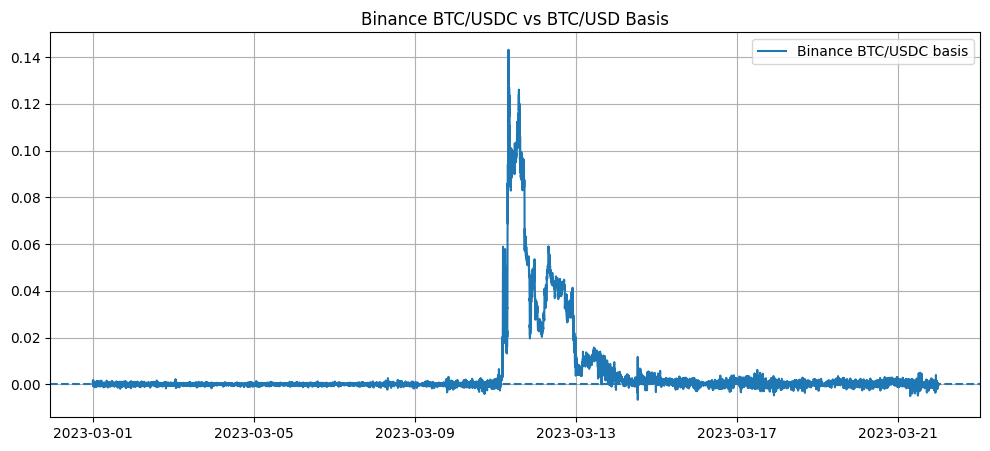

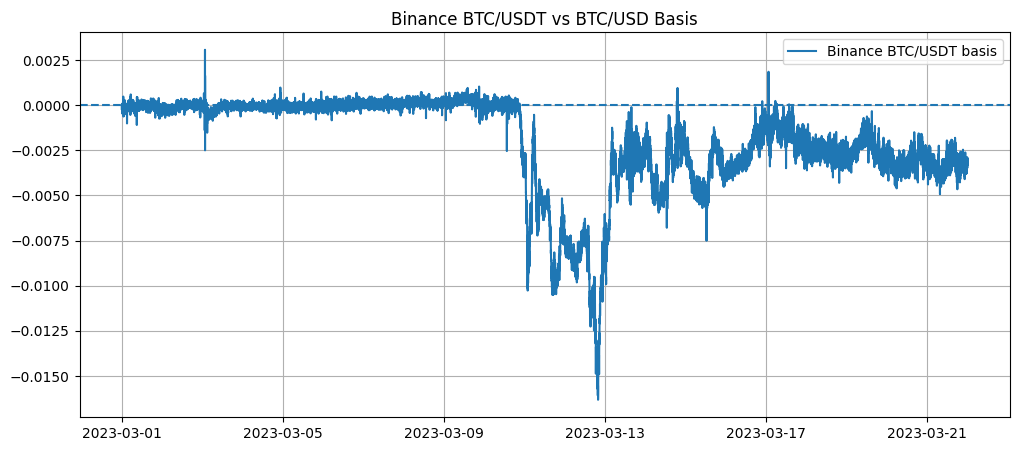

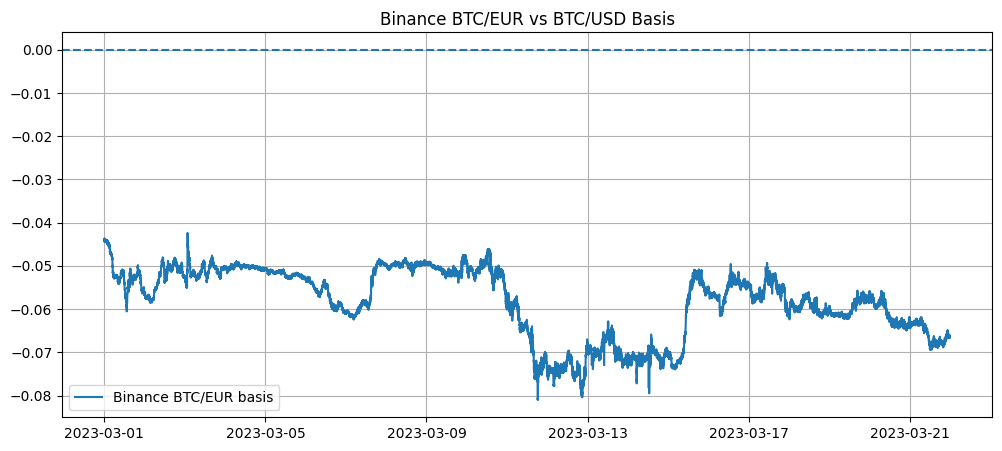

In [ ]:
# Basis plots (run only for available Binance quote datasets)
if datasets.get("binance_usdc") is not None and datasets.get("binance_usd") is not None:
    binance_usdc_basis = compute_and_plot_basis(
        datasets["binance_usdc"],
        datasets["binance_usd"],
        "usdc",
        "Binance"
    )

if datasets.get("binance_usdt") is not None and datasets.get("binance_usd") is not None:
    binance_usdt_basis = compute_and_plot_basis(
        datasets["binance_usdt"],
        datasets["binance_usd"],
        "usdt",
        "Binance"
    )

if datasets.get("binance_eur") is not None and datasets.get("binance_usd") is not None:
    binance_eur_basis = compute_and_plot_basis(
        datasets["binance_eur"],
        datasets["binance_usd"],
        "eur",
        "Binance"
    )